# Introduction

We have previously discussed sentiment classification, which is the task of automatically determining the sentiment expressed in a piece of text. Sentiment classification plays an important role in natural language processing and has numerous practical applications in fields such as social media analysis, customer feedback analysis, and market sentiment prediction. Previously, you have implemented a sentiment classifier using Naive Bayes and a Feed Forward Neural Network. However, in this assignment, you will implement a sentiment classifier using **Long Short-Term Memory (LSTM)** networks applied to the IMDB dataset.

The IMDB dataset, a popular benchmark dataset in sentiment analysis, consists of a collection of movie reviews labeled with their corresponding sentiment (positive or negative). Each review is preprocessed and represented as a sequence of words, with the task being to predict the sentiment polarity based on this textual input.

Long Short-Term Memory networks, a type of recurrent neural network, are particularly well-suited for sequence prediction problems. LSTMs are designed to recognize patterns in sequences of data, such as textual content, where context from earlier in the sequence is essential for understanding the whole. This capability makes LSTMs ideal for tasks like sentiment classification where the meaning can depend heavily on the entire sequence of words.

We're gearing up to implement an LSTM that processes text using word embeddings. Our choice for this task is the GloVe word embedding, a topic we've already explored in detail previously.

By the end of this assignment, you will have gained valuable insights into the application of Long Short-Term Memory networks for sentiment classification tasks and acquired practical skills in designing, training, and evaluating deep learning models on real-world datasets.

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing, models
from tensorflow import keras
from tqdm import tqdm
import tensorflow.keras.utils as ku 
import math


# Data pre-processing


Let's first setup the environment for training our LSTM-based neural network for sentiment classification using the IMDB dataset. We will:

- **Define Parameters:**
    - `vocab_size`: Specifies the number of words to consider as features.
    - `embedding_dim`: Sets the dimensionality of word embeddings.
    - `maxlen`: Determines the maximum length of a sentence to be fed into the network.
- **Load the IMDB Dataset:**
    - Uses the keras.datasets.imdb.load_data function to load the IMDB dataset, which consists of movie reviews labeled with their corresponding sentiment (positive or negative).
    - Sets parameters such as `num_words`, `start_char`, `oov_char`, and `index_from` for loading the data.
- **Retrie Word Index Mapping:**
    - Retrieves the word index file mapping words to indices using `keras.datasets.imdb.get_word_index()`.
- **Create Reverse Word Index Mapping:**
    - Reverses the word index to obtain a dictionary mapping indices to words (id_to_word).
    - Adds special characters `[PAD`], `[START]`, and `[OOV]` to id_to_word to handle padding, start of sequence, and out-of-vocabulary words.
- **Updating Vocabulary Size:**
    - Updates vocab_size to account for the special characters added (`[PAD]`, `[START]`, and `[OOV]`).


These data preprocessing steps are required before training the network for sentiment classification on the IMDB dataset.

In [2]:
# Number of words to consider as features
vocab_size = 10000
# Dimensionality of word embeddings
embedding_dim = 50
# Maximum length of a sentence we will feed to our network
maxlen = 250 

# Load the data as lists of integers.

# Use the default parameters to keras.datasets.imdb.load_data
pad_char = 0  # Character used for padding sequences
start_char = 1  # Character used to indicate the start of a sequence
oov_char = 2  # Character used to indicate out-of-vocabulary words
index_from = 2  # Index offset for word indices

# Retrieve the training sequences.
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=vocab_size, start_char=start_char, oov_char=oov_char, index_from=index_from
)

# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()

# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
id_to_word = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)

# Update `id_to_word` to include special characters: `[PAD]`, `[START]`, and `[OOV]`
id_to_word[pad_char] = "[PAD]"
id_to_word[start_char] = "[START]"
id_to_word[oov_char] = "[OOV]"

# Create a word index mapping indices to words
word_index = dict(
    (i, word) for (word, i) in id_to_word.items()
)

# Update `vocab_size` to account for special characters: `[PAD]`, `[START]`, and `[OOV]`
vocab_size = vocab_size + 3


Now, we perform sequence padding on both the training and test sets to ensure uniform length before feeding them into a neural network for sentiment analysis. Specifically, we use the `preprocessing.sequence.pad_sequences` function to pad or truncate sequences to a fixed length (`maxlen`). This is a common preprocessing step in natural language processing tasks to enable batch processing and uniform input size for neural networks.




In [3]:
# Pad the sequences in the training set to ensure uniform length.

# `preprocessing.sequence.pad_sequences` pads or truncates sequences to a fixed length.
# `maxlen` specifies the maximum length of sequences after padding or truncation.

# `x_train` contains the training sequences to be padded.
# `x_train_padded` will store the padded sequences.

x_train_padded = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)

# Pad the sequences in the test set to ensure uniform length.

# Similar to the training set, sequences in the test set are padded or truncated to the same length.
# `x_test` contains the test sequences to be padded.
# `x_test_padded` will store the padded sequences.

x_test_padded = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)


Let's display the first padded training sequence as a comprehensible sentence, accompanied by its sentiment label to gain insight into the preprocessed data. This visualization aids in understanding the data structure and ensures the correctness of preprocessing steps before model training.

In [ ]:
print(' '.join([id_to_word[id_] for id_ in x_train_padded[0]]))
print(f'{y_train[0]}')

We will now download and extract the GloVe word embedding file and we will use `glove.6B.50d.txt` in which each word is represented using a 50 dimentional space.

In [4]:
data_url = "http://nlp.stanford.edu/data/wordvecs/glove.6B.zip"
data_path = keras.utils.get_file("glove.6B.zip", data_url, extract=True)
data_path = os.path.dirname(data_path)+'/glove.6B.50d.txt'


In [5]:
# Initialize an empty dictionary to store word embeddings
embeddings_index = {}

# Open the GloVe word embedding file for reading
f = open(data_path)

# Iterate through each line in the file
for line in f:
    # Split each line into a list of values (space-separated)
    values = line.split()
    # Extract the word (the first value in the list)
    word = values[0]
    # Convert the remaining values to a NumPy array of float32 type,
    # representing the word vector (embedding)
    coefs = np.asarray(values[1:], dtype='float32')
    # Add the word and its corresponding embedding to the dictionary
    embeddings_index[word] = coefs

# Close the file after processing
f.close()

# Print the total number of word vectors (embeddings) loaded
print('Found %s word vectors.' % len(embeddings_index))


Found 400001 word vectors.


We now iterate through each word in the vocabulary, retrieves its pre-trained GloVe embedding vector (if available), and assigns it to the corresponding row in the embedding matrix. If no pre-trained embedding is found for a word, the corresponding row in the embedding matrix remains all-zeros.


In [6]:
# Initialize an empty matrix to store the embedding vectors for each word in the vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Iterate through each word index in the vocabulary
for id_ in range(vocab_size):
    # Retrieve the word corresponding to the current index
    word = id_to_word[id_]
    # Attempt to retrieve the embedding vector for the word from the pre-trained GloVe embeddings
    embedding_vector = embeddings_index.get(word)
    # Check if an embedding vector is found for the word
    if embedding_vector is not None:
        # If an embedding vector is found, assign it to the corresponding row in the embedding matrix
        embedding_matrix[id_] = embedding_vector
    # If no embedding vector is found (i.e., the word is not present in the pre-trained embeddings),
    # the corresponding row in the embedding matrix remains all-zeros, indicating that the word has no pre-trained embedding


# Define the network

Let's construct the feedforward neural network based on the following architecture. We'll feed the word embeddings in a given sequence to an LSTM layer, and then we will use a dense layer for the final sentiment classification.

![Image Title](architecture.png)

## <span style="color:red"><b>Task 1</b></span>
Implement this architecture:


In [10]:
### START CODE HERE ###
from tensorflow.keras.layers import InputLayer, Embedding, LSTM, Dense
model = models.Sequential([
    InputLayer(input_shape=(maxlen,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False),
    LSTM(units=32),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
### END CODE HERE ###


Run this cell to start training:

In [11]:
history = model.fit(x_train_padded, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test_padded, y_test))

Epoch 1/50


2024-06-12 17:35:18.652864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5895 - loss: 0.6647 - val_accuracy: 0.7265 - val_loss: 0.5575
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7056 - loss: 0.5793 - val_accuracy: 0.7607 - val_loss: 0.5097
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7552 - loss: 0.5136 - val_accuracy: 0.7748 - val_loss: 0.4859
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7752 - loss: 0.4828 - val_accuracy: 0.7952 - val_loss: 0.4518
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7963 - loss: 0.4422 - val_accuracy: 0.8050 - val_loss: 0.4288
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8005 - loss: 0.4332 - val_accuracy: 0.8186 - val_loss: 0.4042
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8243 - loss: 0.3996 - val_accuracy: 0.8248 - val_loss: 0.3954
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8234 - loss: 0.3900 - val_accuracy: 0.83

# Visualization
Let's plot the learning curves for our network:


In [14]:
history.history

{'accuracy': [0.6433200240135193,
  0.7181199789047241,
  0.758400022983551,
  0.7857999801635742,
  0.7982000112533569,
  0.8084800243377686,
  0.8223199844360352,
  0.828000009059906,
  0.8343999981880188,
  0.8417999744415283,
  0.8482000231742859,
  0.8514400124549866,
  0.8551200032234192,
  0.8579199910163879,
  0.8590400218963623,
  0.864799976348877,
  0.8676000237464905,
  0.8678399920463562,
  0.8696399927139282,
  0.8732799887657166,
  0.8758800029754639,
  0.8784000277519226,
  0.880079984664917,
  0.883080005645752,
  0.8845199942588806,
  0.8863599896430969,
  0.8852400183677673,
  0.8907999992370605,
  0.8915200233459473,
  0.8907999992370605,
  0.8942000269889832,
  0.8985599875450134,
  0.8937600255012512,
  0.9005600214004517,
  0.9021599888801575,
  0.9031999707221985,
  0.9023200273513794,
  0.9067999720573425,
  0.9088000059127808,
  0.9089599847793579,
  0.9115999937057495,
  0.9124000072479248,
  0.913919985294342,
  0.9178799986839294,
  0.9155200123786926,
  0.

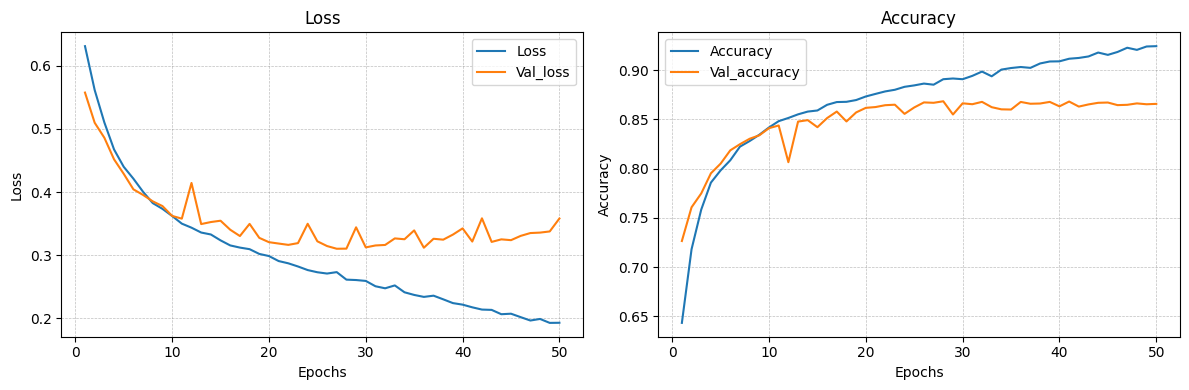

In [15]:
plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
x = range(1, len(history.history['loss']) + 1)
plt.plot(x, history.history['loss'], label='Loss')
plt.plot(x, history.history['val_loss'], label='Val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(x, history.history['accuracy'], label='Accuracy')
plt.plot(x, history.history['val_accuracy'], label='Val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


## <span style="color:red"><b>Task 2</b></span>

Calculate precision, recall, f1-score, and accuracy.
How is the performance obrained compared to the previous sentiment classifiers you have build in this unit?


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


y_pred = (model.predict(x_test_padded) > 0.5).astype("int32")

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Precision: 0.8423
Recall: 0.9000
F1 Score: 0.8702
Accuracy: 0.8658


### Performance Comparison: Naive Bayes vs. RNN on IMDB Dataset


1. **Accuracy:**
   - **Naive Bayes:** 75.24%
   - **RNN:** 86.58%
   
   The RNN outperforms Naive Bayes by a significant margin in terms of accuracy, indicating that the RNN makes fewer overall classification errors.

2. **Precision:**
   - **Naive Bayes:** 77.47%
   - **RNN:** 84.23%
   
   Higher precision for the RNN suggests it has a lower rate of false positives compared to Naive Bayes.

3. **Recall:**
   - **Naive Bayes:** 71.18%
   - **RNN:** 90.00%
   
   The RNN also achieves a higher recall, meaning it is better at correctly identifying positive instances (true positives) and has fewer false negatives.

4. **F1-score:**
   - **Naive Bayes:** 74.19%
   - **RNN:** 87.02%
   
   The F1-score, which balances precision and recall, is notably higher for the RNN. This indicates that the RNN has a more balanced performance across both precision and recall compared to Naive Bayes.

### Conclusion

The RNN demonstrates superior performance across all metrics (accuracy, precision, recall, and F1-score) compared to the Naive Bayes classifier. This suggests that for the IMDB sentiment classification task, the RNN is a more effective model, likely due to its ability to capture temporal dependencies and complex patterns in the text data that Naive Bayes, with its simpler probabilistic approach, cannot.

# Congratulations!


Congratulations on completing the assignment! Your dedication and effort are commendable. By successfully working through this coding exercise, you should have gained valuable insights into the application of RNN-based neural networks for sentiment classification tasks and acquired practical skills in designing, training, and evaluating deep learning models on real-world datasets.






# Acknowledgement

## About the Author

This notebook was authored by Mohamed Reda Bouadjenek. He is a Senior Lecturer (Assistant Professor) of Applied Artificial Intelligence in the School of Information Technology at Deakin University, Australia.



## Disclaimer 

Even though your code passes all unit test cases, it does not guarantee absolute correctness. The complexity of real-world scenarios can sometimes lead to unforeseen edge cases that may not have been covered by the test suite. As a result, it's essential to exercise caution and conduct thorough testing to ensure the robustness and reliability of the code in all possible cases.

## Version History
- Version 1.0 (Initial Release): Released on 06/05/2024.

## Contact Information

- **Email:** reda.bouadjenek@deakin.edu.au
- **GitHub:** https://github.com/rbouadjenek/

---
